# Exercise 02: Multi-class Classification 
In this exercise, you will train a deep model on the CIFAR10 from the scratch using PyTorch. The following tasks should be done:
- Task 1: per batch training/testing
- Task 2: Instance inference and visualization

### Basic Imports

In [36]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [37]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [39]:
# cifar10 transform
# 定义训练的transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),# 随机翻转
    transforms.ToTensor(),# 表明，用transform把输入转化为张量
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# 定义检测的transform
transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 搞出训练集：路径，是目标路径的训练集，下载与否，使用上面定义的transform
train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
# 搞出训练集加载器：..., 2线程
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [40]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [41]:
model = ConvNet().to(device)

### Optimizer

In [42]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [43]:
##################### Write your answer here ##################
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
###############################################################

In [44]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################
    return output, loss

In [45]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [46]:
from tqdm import tqdm
import time
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):

    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    with tqdm(total=len(train_dataloader), desc='Epoch %d' % epoch) as pbar:
        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)


            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pbar.update(1)

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # epoch_loss是普通浮点数
    training_loss.append(epoch_loss)
    # epoch_acc在GPU上
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:

            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch 0: 100%|██████████| 391/391 [00:06<00:00, 64.34it/s]

Epoch: 1/30 Train Loss: 0.0150 Acc: 0.2853
Begin test......


Test Loss: 0.0146 Acc: 0.3363


Epoch 1: 100%|██████████| 391/391 [00:06<00:00, 61.94it/s]

Epoch: 2/30 Train Loss: 0.0141 Acc: 0.3350
Begin test......


Test Loss: 0.0138 Acc: 0.3641


Epoch 2: 100%|██████████| 391/391 [00:06<00:00, 63.08it/s]

Epoch: 3/30 Train Loss: 0.0140 Acc: 0.3357
Begin test......


Test Loss: 0.0131 Acc: 0.3965


Epoch 3: 100%|██████████| 391/391 [00:06<00:00, 63.26it/s]

Epoch: 4/30 Train Loss: 0.0137 Acc: 0.3556
Begin test......


Test Loss: 0.0133 Acc: 0.3699


Epoch 4: 100%|██████████| 391/391 [00:06<00:00, 63.43it/s]

Epoch: 5/30 Train Loss: 0.0136 Acc: 0.3626
Begin test......


Test Loss: 0.0130 Acc: 0.4059


Epoch 5: 100%|██████████| 391/391 [00:06<00:00, 62.93it/s]

Epoch: 6/30 Train Loss: 0.0126 Acc: 0.4097
Begin test......


Test Loss: 0.0116 Acc: 0.4660


Epoch 6: 100%|██████████| 391/391 [00:06<00:00, 64.25it/s]

Epoch: 7/30 Train Loss: 0.0124 Acc: 0.4227
Begin test......


Test Loss: 0.0116 Acc: 0.4726


Epoch 7: 100%|██████████| 391/391 [00:06<00:00, 63.28it/s]

Epoch: 8/30 Train Loss: 0.0122 Acc: 0.4326
Begin test......


Test Loss: 0.0116 Acc: 0.4718


Epoch 8: 100%|██████████| 391/391 [00:06<00:00, 63.47it/s]

Epoch: 9/30 Train Loss: 0.0121 Acc: 0.4372
Begin test......


Test Loss: 0.0114 Acc: 0.4785


Epoch 9: 100%|██████████| 391/391 [00:06<00:00, 63.17it/s]

Epoch: 10/30 Train Loss: 0.0119 Acc: 0.4484
Begin test......


Test Loss: 0.0112 Acc: 0.4889


Epoch 10: 100%|██████████| 391/391 [00:06<00:00, 62.52it/s]

Epoch: 11/30 Train Loss: 0.0114 Acc: 0.4718
Begin test......


Test Loss: 0.0107 Acc: 0.5179


Epoch 11: 100%|██████████| 391/391 [00:06<00:00, 64.24it/s]

Epoch: 12/30 Train Loss: 0.0113 Acc: 0.4790
Begin test......


Test Loss: 0.0106 Acc: 0.5137


Epoch 12: 100%|██████████| 391/391 [00:06<00:00, 63.51it/s]

Epoch: 13/30 Train Loss: 0.0112 Acc: 0.4840
Begin test......


Test Loss: 0.0106 Acc: 0.5184


Epoch 13: 100%|██████████| 391/391 [00:06<00:00, 63.80it/s]

Epoch: 14/30 Train Loss: 0.0111 Acc: 0.4828
Begin test......


Test Loss: 0.0106 Acc: 0.5244


Epoch 14: 100%|██████████| 391/391 [00:06<00:00, 64.02it/s]

Epoch: 15/30 Train Loss: 0.0110 Acc: 0.4922
Begin test......


Test Loss: 0.0106 Acc: 0.5292


Epoch 15: 100%|██████████| 391/391 [00:06<00:00, 64.48it/s]

Epoch: 16/30 Train Loss: 0.0107 Acc: 0.5090
Begin test......


Test Loss: 0.0099 Acc: 0.5545


Epoch 16: 100%|██████████| 391/391 [00:06<00:00, 63.89it/s]

Epoch: 17/30 Train Loss: 0.0106 Acc: 0.5130
Begin test......


Test Loss: 0.0100 Acc: 0.5526


Epoch 17: 100%|██████████| 391/391 [00:06<00:00, 63.06it/s]

Epoch: 18/30 Train Loss: 0.0105 Acc: 0.5153
Begin test......


Test Loss: 0.0097 Acc: 0.5633


Epoch 18: 100%|██████████| 391/391 [00:06<00:00, 63.49it/s]

Epoch: 19/30 Train Loss: 0.0104 Acc: 0.5191
Begin test......


Test Loss: 0.0098 Acc: 0.5577


Epoch 19: 100%|██████████| 391/391 [00:06<00:00, 64.18it/s]

Epoch: 20/30 Train Loss: 0.0105 Acc: 0.5182
Begin test......


Test Loss: 0.0100 Acc: 0.5441


Epoch 20: 100%|██████████| 391/391 [00:06<00:00, 63.86it/s]

Epoch: 21/30 Train Loss: 0.0102 Acc: 0.5320
Begin test......


Test Loss: 0.0095 Acc: 0.5696


Epoch 21: 100%|██████████| 391/391 [00:06<00:00, 63.12it/s]

Epoch: 22/30 Train Loss: 0.0102 Acc: 0.5318
Begin test......


Test Loss: 0.0096 Acc: 0.5705


Epoch 22: 100%|██████████| 391/391 [00:06<00:00, 63.62it/s]

Epoch: 23/30 Train Loss: 0.0101 Acc: 0.5354
Begin test......


Test Loss: 0.0095 Acc: 0.5716


Epoch 23: 100%|██████████| 391/391 [00:06<00:00, 64.01it/s]

Epoch: 24/30 Train Loss: 0.0101 Acc: 0.5398
Begin test......


Test Loss: 0.0095 Acc: 0.5745


Epoch 24: 100%|██████████| 391/391 [00:06<00:00, 62.87it/s]

Epoch: 25/30 Train Loss: 0.0101 Acc: 0.5366
Begin test......


Test Loss: 0.0094 Acc: 0.5753


Epoch 25: 100%|██████████| 391/391 [00:06<00:00, 63.47it/s]

Epoch: 26/30 Train Loss: 0.0100 Acc: 0.5465
Begin test......


Test Loss: 0.0093 Acc: 0.5848


Epoch 26: 100%|██████████| 391/391 [00:06<00:00, 62.79it/s]

Epoch: 27/30 Train Loss: 0.0100 Acc: 0.5445
Begin test......


Test Loss: 0.0094 Acc: 0.5743


Epoch 27: 100%|██████████| 391/391 [00:06<00:00, 62.70it/s]

Epoch: 28/30 Train Loss: 0.0099 Acc: 0.5448
Begin test......


Test Loss: 0.0093 Acc: 0.5813


Epoch 28: 100%|██████████| 391/391 [00:06<00:00, 63.39it/s]

Epoch: 29/30 Train Loss: 0.0099 Acc: 0.5488
Begin test......


Test Loss: 0.0093 Acc: 0.5878


Epoch 29: 100%|██████████| 391/391 [00:06<00:00, 62.85it/s]

Epoch: 30/30 Train Loss: 0.0099 Acc: 0.5455
Begin test......


Test Loss: 0.0093 Acc: 0.5870


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [47]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0].to(device)
print(input)

tensor([[[ 0.6338,  0.6531,  0.7694,  ...,  0.2267,  0.0134, -0.1804],
         [ 0.5174,  0.4981,  0.6531,  ...,  0.2073, -0.0060, -0.1223],
         [ 0.4981,  0.4981,  0.6338,  ...,  0.2654,  0.0910, -0.1029],
         ...,
         [-1.1109, -1.6149, -1.8281,  ..., -1.6924, -2.1771, -1.6537],
         [-1.2466, -1.4792, -1.7506,  ..., -1.9251, -1.8669, -2.0414],
         [-1.3823, -1.3435, -1.5567,  ..., -1.9638, -1.7700, -2.0220]],

        [[-0.2156, -0.2352, -0.1369,  ..., -0.5499, -0.6286, -0.7466],
         [-0.2156, -0.2549, -0.1762,  ..., -0.5499, -0.6286, -0.6876],
         [-0.2549, -0.2746, -0.2352,  ..., -0.4909, -0.5499, -0.6679],
         ...,
         [ 0.0204, -0.4516, -0.6876,  ..., -0.5106, -1.1596, -0.7466],
         [-0.1369, -0.4122, -0.7466,  ..., -0.8056, -0.8056, -1.1596],
         [-0.3139, -0.3532, -0.6679,  ..., -0.9039, -0.7662, -1.1006]],

        [[-1.2654, -1.3044, -1.2264,  ..., -1.5190, -1.5190, -1.5776],
         [-1.2264, -1.4410, -1.3434,  ..., -1

In [48]:
output=model(input)

In [49]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
probabilities = F.softmax(output, dim=1)
predict_label= torch.max(probabilities, dim=1).indices

print(probabilities[0].tolist())
print(predict_label)


[0.009652365930378437, 0.013954898342490196, 0.03104851394891739, 0.5647620558738708, 0.019605951383709908, 0.245577871799469, 0.04209057241678238, 0.01624736562371254, 0.03462742269039154, 0.022432943806052208]
tensor([3], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
0.5647620558738708


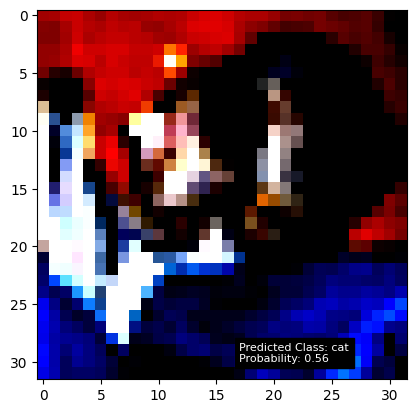

Print probabilities for each class:
airplane: 0.0097
automobile: 0.0140
bird: 0.0310
cat: 0.5648
deer: 0.0196
dog: 0.2456
frog: 0.0421
horse: 0.0162
ship: 0.0346
truck: 0.0224


In [50]:
predicted_class = class_names[predict_label.item()]
print(predict_label.item())

predicted_probability = probabilities[0].tolist()[predict_label.item()]
print(predicted_probability)

image = inputs[0].numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0].tolist()[i]:.4f}')